An interesting methodological dilemma was posted by Austin Mullings on the [CogSci Stack Exchange](http://cogsci.stackexchange.com/questions/12118/can-we-use-a-scale-even-if-one-of-the-answer-levels-was-not-added). The situation is the following:

> I have a set of 20 participants for a study who were given a 7-point Likert scale that was made incorrectly by a graduate student. The student accidentally did not add the 6th answer level.

What can we infer from the data produced by this imperfect experiment?

As with any estimator $\hat \theta$ of the true performance $\theta$ there are two things to be concerned about:

1. Bias:  $E[\hat \theta - \theta]$
2. Variance: $Var[\hat \theta - \theta]$
    
We ask, how the omission of 6th label from the 7-point Likert scale affects the bias and the variance of the estimator. Note that there are multiple ways to analyze the data and to estimate the performance of the subject. Question does not specify this. I will consider two different estimators:

1. Raw score average
2. Ability estimate with [ordered logistic regression](https://en.wikipedia.org/wiki/Ordered_logit) which implements the [Rasch model](https://en.wikipedia.org/wiki/Rasch_model)
    
I investigate the bias and variance with a fake-data simulation.

First, I generate data from an ordered logistic regression with 7 labels with thresholds at $c=(0.0,1.4,2.6,4.2,6.0,7.0)$ for subject $i$ with ability $\theta_i$ ranging from $-5$ to $12$. For the thresholds I just chose some values with irregular spacing. The range of $\theta$ was chosen to cover the thresholds. I generated $200$ measurements for each subject. Each measurement is an integer value ranging from $1$ to $7$. To simulate the omission of the 6th label I created an additional dataset. I generated $1000$ measurements from the ordered logit model and retained the first non-$6$ valued measurements.

Next, I estimate the ability and the thresholds with ordered logistic regression. I estimate a separate $\hat \theta_i$ for each subject.  

In [1]:
%pylab inline
from matustools.matusplotlib import *
import warnings
warnings.filterwarnings("ignore")
import pystan
from scipy.stats import scoreatpercentile as sap

model='''data {
    int<lower=2> K; //nr labels
    int<lower=0> N; // nr repetitions
    int<lower=1> M; // nr subjects/ ability values
    vector[M] beta;
    ordered[K-1] c;
    }
    parameters{real<lower=K-1,upper=K+1> dummy;}
    model {K~normal(dummy,N);}
    generated quantities{
        int<lower=1,upper=K> y[M]; 
        for (m in 1:M){
            //for (n in 1:N) 
            y[m] <- ordered_logistic_rng(beta[m], c);
    }}
'''
sm=pystan.StanModel(model_code=model)

Populating the interactive namespace from numpy and matplotlib


In [2]:
c=np.array([0,1.4,2.6,4.2,6.0,7.0])
beta=np.linspace(-5,12,31)
dat={'K':c.size+1,'c':c,'N':100,'M':beta.size,'beta':beta}
fit = sm.sampling(data=dat,iter=400, chains=6,
    thin=1,warmup=0,n_jobs=6,seed=4)
N=200
y=fit.extract()['y']
y1=y[:N,:]
y2=np.zeros(y1.shape)
for k in range(y1.shape[1]):
    temp=y[y[:,k]!=6,k]
    assert temp.size>=N
    y2[:,k]=temp[:N]

In [3]:
model='''
data {
    int<lower=2> K;
    int<lower=0> N;
    int<lower=1> M;
    int<lower=1,upper=K> y[N,M]; 
}
parameters {
    vector<lower=-100,upper=100>[M-1] beta;
    ordered[K-1] c;
}
transformed parameters{
    vector[M] bbeta;
    bbeta[1]<-0;
    for (m in 2:M) bbeta[m]<-beta[m-1];
}
model {
for (k in 1:(K-1)) c[k]~ uniform(-10,10);
for (m in 1:M){
    for (n in 1:N) y[n,m] ~ ordered_logistic(bbeta[m], c);
}}
'''
smOL=pystan.StanModel(model_code=model)

In [4]:
dat={'K':c.size+1,'N':y1.shape[0],'M':beta.size,'y':np.int32(y1)}
fit = smOL.sampling(data=dat,iter=3000, chains=6,
    thin=5,warmup=1000,n_jobs=6,seed=4)
saveStanFit(fit,'ol1')

In [5]:
dat={'K':c.size+1,'N':y1.shape[0],'M':beta.size,'y':np.int32(y2)}
fit = smOL.sampling(data=dat,iter=3000, chains=6,
    thin=5,warmup=1000,n_jobs=6,seed=4)
saveStanFit(fit,'ol2')

In [6]:
c0=np.copy(c)
beta0=np.copy(beta)
ol1=loadStanFit('ol1')
ol2=loadStanFit('ol2')
c1=ol1['c']
c2=ol2['c']
beta1=ol1['bbeta']
beta2=ol2['bbeta']
k=0
beta0-=c0[k]
c0-=c0[k]
for i in range(beta1.shape[1]): 
    beta1[:,i]-=c1[:,k]
    beta1[:,i]-=beta0[i]
temp=np.copy(c1[:,k])
for i in range(c1.shape[1]): c1[:,i]-=temp
for i in range(beta2.shape[1]): 
    beta2[:,i]-=c2[:,k]
    beta2[:,i]-=beta0[i]
temp=np.copy(c2[:,k])
for i in range(c2.shape[1]): c2[:,i]-=temp

In [7]:
def _errorbar(out,x,clr='k'):
    plt.plot(out[1:3],[x,x],color=clr)
    plt.plot(out[3:5],[x,x],
        color=clr,lw=3,solid_capstyle='round')
    plt.plot([out[0]],[x],mfc=clr,mec=clr,ms=8,marker='|',mew=2)
    
def errorbar(y,clr='r',x=None,labels=None):
    out=[]
    d=np.array(y);
    if d.ndim<2: d=np.array(y,ndmin=2).T
    if not x is None: x=np.array(x)
    if x is None or x.size==0: x=np.arange(d.shape[1])
    elif x.size==1: 
        x=np.ones(d.shape[1])*x[0]
        doxticks=False
    elif x.ndim!=1 or x.shape[0]!=d.shape[1]:
        x=np.arange(0,d.shape[1])
    ax=plt.gca()
    print x,y.shape
    for i in range(d.shape[1]):
        out.append([np.median(d[:,i]),sap(d[:,i],2.5),sap(d[:,i],97.5),
                    sap(d[:,i],25),sap(d[:,i],75)])
        _errorbar(out[-1],x=x[i],clr=clr)
def plotConfidenceBand(x,y,clr='r'):
    m=np.median(y,axis=0)
    l=sap(y,2.5,axis=0)
    u=sap(y,97.5,axis=0)
    plt.plot(x,m,color=clr)
    xx=np.concatenate([x,x[::-1]])
    ci=np.concatenate([u,l[::-1]])
    plt.gca().add_patch(plt.Polygon(np.array([xx,ci]).T,
                alpha=0.2,fill=True,fc=clr,ec=clr))
    plt.xlim(x[[0,-1]])

[-1.28240274 -1.2569352  -1.25191406 -1.22993204 -1.21284466 -1.20149319] (2400, 6)
[-1.47544024 -1.45333417 -1.45296879 -1.44404141 -1.42694402 -1.42421622] (2400, 6)


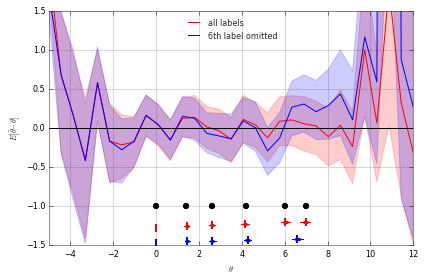

In [8]:
plotConfidenceBand(beta0,beta1)
plotConfidenceBand(beta0,beta2,clr='b')
plt.ylim([-1.5,1.5])
plt.plot(beta0,np.zeros(beta0.shape),'k')
plt.plot(c0,np.ones(c0.size)*-1,'ok')
#errorbar(c1,x=-1.3+np.sort(0.1*np.random.rand(c1.shape[1])));
#errorbar(c2,x=-1.5+np.sort(0.1*np.random.rand(c2.shape[1])),clr='b');
plt.xlabel('$\\theta$');plt.ylabel('$E[\\hat \\theta -\\theta]$')
plt.legend(['all labels','6th label omitted'],loc=9);

The figure above shows the bias (y axis) in relation to the true ability (x axis). The bias of the estimate for a sample with all labels and with the label 6 omitted is shown by the red and blue curve respectively. The blue and red surface show the 95% percentile interval for the respective dataset and as such gives an idea about the variance of the estimator. To give a better idea of what the x axis shows I have drawn the true threshold values as black dots. Scores of 1 dominate below the first threshold, scores of 2 are located between the first and second threshold and so on. Figure shows that the ability estimate is not affected by the omission of the 6th label when the ability is below the fourth threshold. This is plausible - subjects with low ability will produce only few 6 scores and hence their ability estimate is unaffected by the omission of this label. Looking at the ability above the fourth threshold we observe bias. My guess is that the direction of this bias depends on the gaps between the 4th, 5th and 6th thresholds. Possibly, with equal spacing there would be no bias. For the current choice of the thresholds the bias edges on significance for a sample size of $200$. Irrespective of bias the figure indicates a slightly higher estimator variance above the sixth threshold. Note that the ability estimate of ordered logit always shows higher variance at the edges of the ability spectrum. The omission of the 6th label means that the 5th and 6th threshold are collapsed together. As a consequence 6th threshold is lower for the all-labels dataset than for the label-omitted dataset. As another consequence the high variance area at the higher ability edge is pulled towards middle.

Next, I investigated the raw averages.

In [9]:
model='''
data {
    int<lower=2> K;
    int<lower=0> N;
    int<lower=1> M;
    real<lower=1,upper=K> y[N,M]; 
}
parameters {
    real<lower=-100,upper=100> mu[M];
    real<lower=0.01,upper=100> sigma[M];
}

model {
    for (m in 1:M){
    for (n in 1:N) y[n,m] ~ normal(mu[m],sigma[m]);
}}
'''
smN=pystan.StanModel(model_code=model)

In [10]:
dat={'K':c.size+1,'N':y1.shape[0],'M':beta.size,'y':y1}
fit = smN.sampling(data=dat,iter=3000, chains=6,
    thin=5,warmup=1000,n_jobs=6,seed=4)
saveStanFit(fit,'n1')

In [11]:
dat={'K':c.size+1,'N':y1.shape[0],'M':beta.size,'y':y2}
fit = smN.sampling(data=dat,iter=3000, chains=6,
    thin=5,warmup=1000,n_jobs=6,seed=4)
saveStanFit(fit,'n2')

In [12]:
c0=np.copy(c)
beta0=np.copy(beta)
ol1=loadStanFit('n1')
ol2=loadStanFit('n2')
m1=ol1['mu']
m2=ol2['mu']
m0=[]
for bb in beta0.tolist():
    m0.append([0])
    for i in range(len(c0)):
        m0[-1].append(1/(1+np.exp(-c0[i]+bb)))
    m0[-1].append(1)
    m0[-1]=np.diff(m0[-1])
    m0[-1]=np.sum(m0[-1]*np.arange(1,8))
m0=np.array(m0)
for i in range(m2.shape[1]): 
    m1[:,i]-=m0[i]
    m2[:,i]-=m0[i]

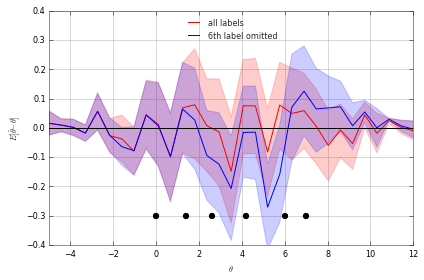

In [13]:
plotConfidenceBand(beta0,m1)
plotConfidenceBand(beta0,m2,clr='b')
plt.ylim([-0.4,0.4])
plt.plot(beta0,np.zeros(beta0.shape),'k')
plt.plot(c0,np.ones(c0.size)*-0.3,'ok')
plt.xlabel('$\\theta$');plt.ylabel('$E[\\hat \\theta -\\theta]$')
plt.legend(['all labels','6th label omitted'],loc=9);

In the case of the average score, we observe a similar bias pattern as we observed with the ability estimates of the ordinal logit model. We observe underestimation below the 5th threshold and overestimation above the 5th threshold. The main difference is that the bias affects a much wider range of the ability values above the second threshold. Ordered logit is more robust than the normal model.

To conclude, the ordered logit should be chosen over the analysis of average scores. Further care should be taken when a comparison is made between groups whose mean ability is located in the vicinity of the 5th threshold. Take for instance two groups with $\theta_1=5.8$, $\theta_2=6.2$ and $\delta=\theta_1 - \theta_2=0.4$. From the first figure we can roughly estimate that if the 6th label is missing this would result in the biased estimates $\hat\theta_1=5.6$, $\hat\theta_2=6.4$ and $\hat\delta=0.8$. However, with average group abilities below the fourth threshold it is should be perfectly safe to estimate the ability and the group differences even with the 6th label missing. Furthermore, the estimate of the fourth threshold was not biased in my simulations (see the error bars at the bottom of the first figure) and can be estimated from the data with the missing label.